# Assignment 5

Jesse Perla, UBC

## Student Name/Number: (doubleclick to edit)

### Instructions

-   Edit the above cell to include your name and student number.
-   Submit just this `ipynb` to Canvas. Do not rename, it associates
    your student number with the submission automatically.

In [1]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics, Random, QuantEcon, NLsolve

## Question 1

Recall the [Lake
Model](https://jlperla.github.io/undergrad_computational_macro/slides/markov_chains_applications.html#/lake-model-of-unemployment-and-employment)
of unemployment and employment. Summarizing, while in the labor market,
workers are employed or unemployed, where

-   $\lambda$, the job finding rate for currently unemployed workers and
    $\alpha$ is the dismissal rate for currently employed workers
-   $b$ is the entry rate into the labor force, $d$ is the exit rate,
    and $g = b - d$. New entrance into the labor force is assumed to be
    unemployed.
-   $E_t$ is the total number of employed workers, $U_t$ is the total
    number of unemployed workers and $N_t = E_t + U_t$ is the total
    number of workers in the labor force.
-   The employment and unemployment rate are $e_t \equiv E_t / N_t$ and
    $u_t \equiv U_t / N_t$ respectively.
-   Define $X_t \equiv \left(\begin{matrix}U_t\\E_t\end{matrix}\right)$
    and $x_t \equiv \left(\begin{matrix}u_t\\e_t\end{matrix}\right)$.

With this, we constructed the equation for the evolution of the state
vector $X_{t+1}$ as

$$
X_{t+1} = \underbrace{\begin{bmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{bmatrix}}_{\equiv A} X_t
$$

And

$$
x_{t+1} = \underbrace{\frac{1}{1 + g} A}_{\equiv \hat{A}} x_t
$$

Finally, the Markov chain for an agent (before exit) is

$$
P = \begin{bmatrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{bmatrix}
$$

In the lectures we had code for general simulations using a model and
collection of parameters

In [1]:
# Reusable functions, do not modify
function iterate_map(f, x0, T)
    x = zeros(length(x0), T + 1)
    x[:, 1] = x0
    for t in 2:(T + 1)
        x[:, t] = f(x[:, t - 1])
    end
    return x
end
function lake_model(; lambda = 0.283, alpha = 0.013, b = 0.0124, d = 0.00822)
    g = b - d
    A = [(1 - lambda) * (1 - d)+b (1 - d) * alpha+b
         (1 - d)*lambda (1 - d)*(1 - alpha)]
    P = [(1 - lambda) lambda
         alpha 1 - alpha]
    A_hat = A ./ (1 + g)
    x_0 = ones(size(A_hat, 1)) / size(A_hat, 1)
    sol = fixedpoint(x -> A_hat * x, x_0)
    converged(sol) || error("Failed to converge in $(sol.iterations) iter")    
    x_bar =sol.zero
    return (; lambda, alpha, b, d, A, A_hat, x_bar, P)
end

lake_model (generic function with 1 method)

Using the above code, we can solve for the dynamics of the stocks with


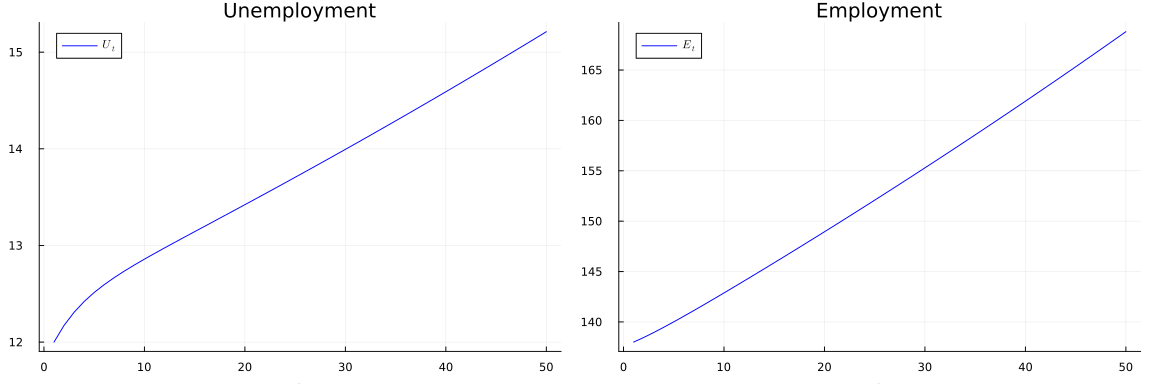

In [1]:
lm = lake_model()
N_0 = 150
e_0 = 0.92
u_0 = 1 - e_0
T = 50
U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]
X_path = iterate_map(X -> lm.A * X, X_0, T - 1)
x1 = X_path[1, :]
x2 = X_path[2, :]
plt_unemp = plot(1:T, X_path[1, :]; color = :blue,
                 label = L"U_t", xlabel="t", title = "Unemployment")
plt_emp = plot(1:T, X_path[2, :]; color = :blue,
               label = L"E_t", xlabel="t", title = "Employment")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

Similarly, we can plot the evolution of the employment and unemployment
rates after finding the steady state:


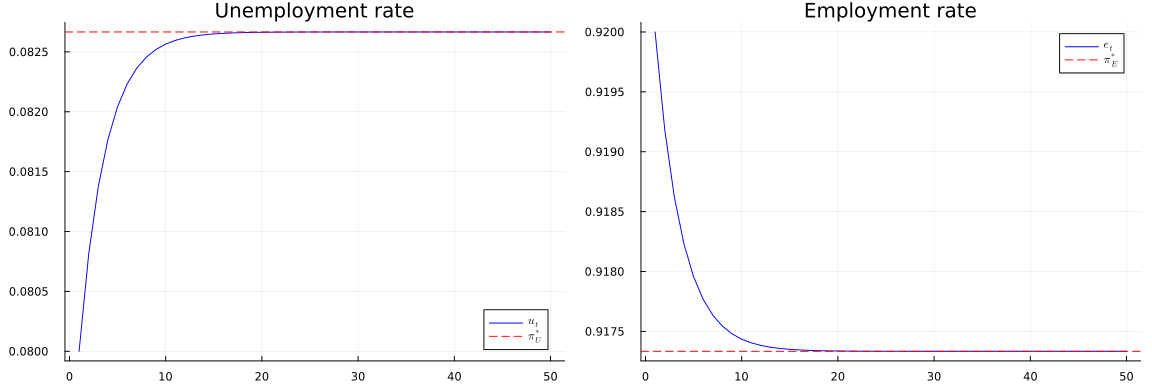

In [1]:
u_bar, e_bar = lm.x_bar
x_0 = [u_0; e_0]
x_path = iterate_map(x -> lm.A_hat * x, x_0, T - 1)
plt_unemp = plot(1:T, x_path[1, :];title = "Unemployment rate", 
                 color = :blue, label = L"u_t")
hline!(plt_unemp, [u_bar], color = :red, linestyle = :dash, label = L"\pi^{*}_U")
plt_emp = plot(1:T, x_path[2, :]; title = "Employment rate", color = :blue, label = L"e_t")
hline!(plt_emp, [e_bar], color = :red, linestyle = :dash,label = L"\pi^{*}_E")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

### Part (a)

Repeating the above code, plot the dynamics of the unemployment and
employment rates for the model with `b = d = 0`, but keeping all of the
other parameters as given.


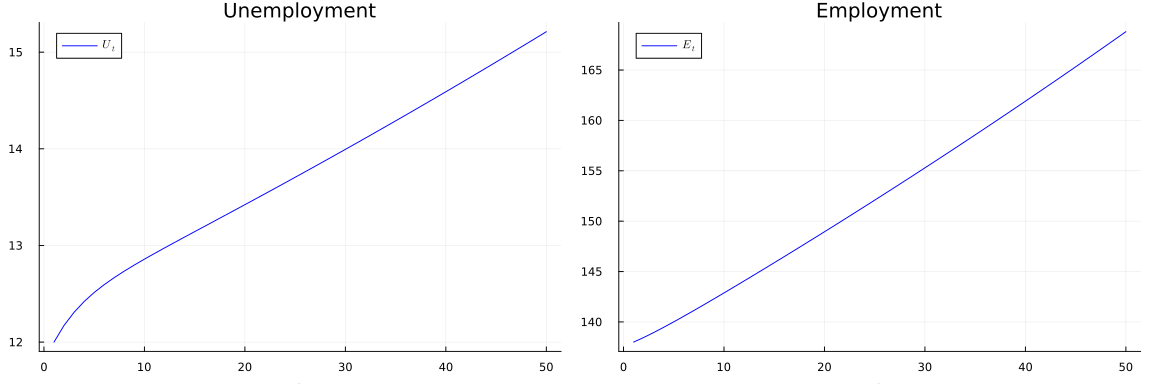

In [1]:
# edit your code here
lm = lake_model()
N_0 = 150
e_0 = 0.92
u_0 = 1 - e_0
T = 50
U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]
X_path = iterate_map(X -> lm.A * X, X_0, T - 1)
x1 = X_path[1, :]
x2 = X_path[2, :]
plt_unemp = plot(1:T, X_path[1, :]; color = :blue,
                 label = L"U_t", xlabel="t", title = "Unemployment")
plt_emp = plot(1:T, X_path[2, :]; color = :blue,
               label = L"E_t", xlabel="t", title = "Employment")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

Interpret why this is different from the previous case (talk about
transition dynamics as well as the steady-states)

**(double click to edit your answer)**

### Part (b)

The Markov chain for an individual starting in the employment state can
be simulated using the markov chain already calculated in our previous
code,


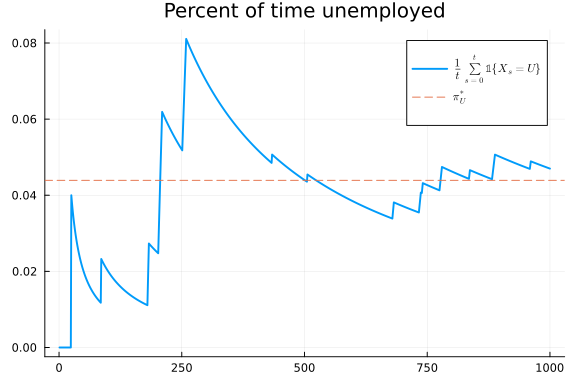

In [1]:
lm = lake_model(;lambda = 0.283, alpha = 0.013, b = 0.0, d = 0.0)
T = 1000
mc = MarkovChain(lm.P, [0; 1])     # 0=unemployed, 1=employed
s_path = simulate(mc, T; init = 2)
u_bar, e_bar = stationary_distributions(mc)[1]
# Note mapping in MarkovChain
s_bar_e = cumsum(s_path) ./ (1:T)
s_bar_u = 1 .- s_bar_e
s_bars = [s_bar_u s_bar_e]
plot(title = "Percent of time unemployed",
 1:T, s_bars[:, 1], lw = 2,
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s = U\}",
 legend=:topright, size=(600, 400))
hline!([u_bar], linestyle = :dash,
       label = L"\pi^{*}_U")

Modify this same graph, but now start the agent in unemployed state,


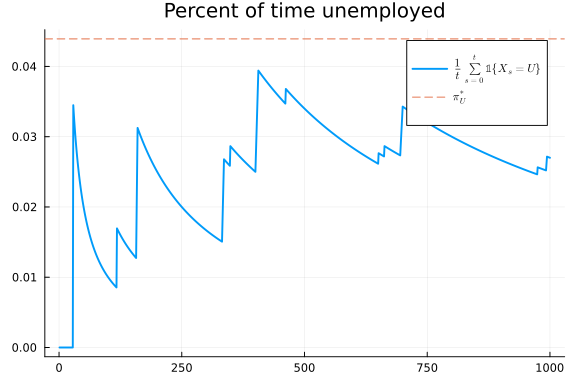

In [1]:
# edit your code here
s_path = simulate(mc, T; init = 2)
u_bar, e_bar = stationary_distributions(mc)[1]
# Note mapping in MarkovChain
s_bar_e = cumsum(s_path) ./ (1:T)
s_bar_u = 1 .- s_bar_e
s_bars = [s_bar_u s_bar_e]
plot(title = "Percent of time unemployed",
 1:T, s_bars[:, 1], lw = 2,
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s = U\}",
 legend=:topright, size=(600, 400))
hline!([u_bar], linestyle = :dash,
       label = L"\pi^{*}_U")

Interpret these graphs. In particular: (1) why are the different; (2)
why does it converge; and (3) why does it converge to the same point?.

**(double click to edit your answer)**

## Question 2

Take the [McCall search model with
separation](https://julia.quantecon.org/dynamic_programming/mccall_model_with_separation.html)
we discussed in class.

That implemented the following Bellman equation:

$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ]
$$

and

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

where $\gamma$ is the probability of a job offer while unemployed,
$\alpha$ is the probability of exogenous separation, $u$ is the utility
function, and $w_i$ is the wage offer with probability $p_i$.

The code which solves for this Bellman Equation is


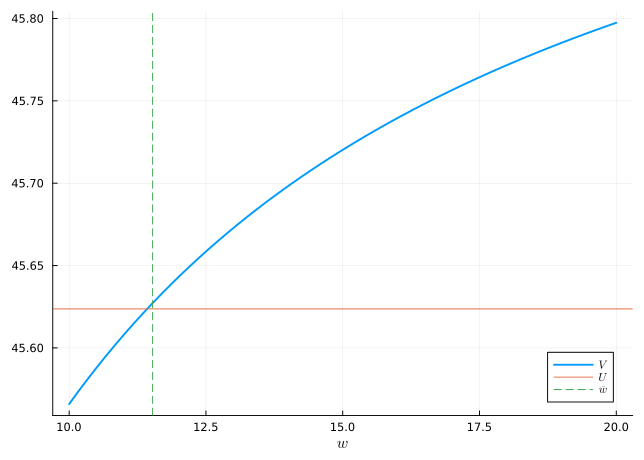

In [1]:
# model constructor
function mccall_model(;
    alpha = 0.2,
    beta = 0.98, # discount rate
    gamma = 0.7,
    c = 6.0, # unemployment compensation
    sigma = 2.0,
    w = range(10, 20, length = 60), # wage values
    dist = BetaBinomial(59, 600, 400)) # distribution over wage values
    return (; alpha, beta, sigma, c, gamma, w, dist, p = pdf.(dist, 0:length(w)-1))
end


function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; alpha, beta, sigma, c, gamma, w, sigma, p) = mcm
    u(c) = (c^(1 - sigma) - 1) / (1 - sigma)
    u_w = u.(w)
    u_c = u.(c)

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        # V_p = u_w + beta * ((1 - alpha) * V .+ alpha * U), or expanding out
        V_p = [ u_w[i] + beta * ((1 - alpha) * V[i] + alpha * U) for i in 1:length(w)]
        U_p = u_c + beta * (1 - gamma) * U + beta * gamma * sum(max(U, V[i]) * p[i] for i in 1:length(w))
        return [V_p; U_p]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (;V, U, w_bar)
end

mcm = mccall_model()
sol = solve_mccall_model(mcm)

plot(mcm.w, sol.V, lw = 2, label = L"V", xlabel=L"w")
hline!(mcm.w, [sol.U], label=L"U")
vline!([sol.w_bar]; linestyle = :dash, label = L"\bar{w}")

Take the above equation, and consider a variation where there is
on-the-job searching for better jobs. With probability $\delta$ the
worker gets a job offer while employed

$$
V(w) = u(w) + \beta [(1-\alpha-\delta)V(w) + \alpha U + \delta \sum_i \max \left\{ V(w), V(w_i) \right\} p_i ]
$$

Note that the $\max$ is taken over the current wage and the arrival with
the same

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

Modify the code above to implement this new Bellman equation. Hint:
after adding the new constant, you will probably only need to change the
`u_w + beta * ((1 - alpha) * V .+ alpha * U)` function to include the
new term.


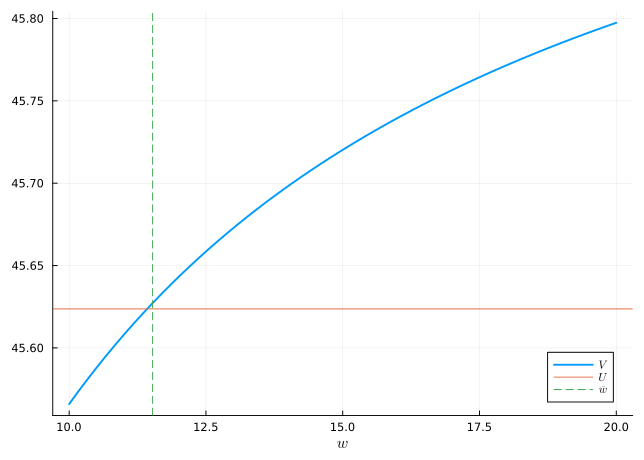

In [1]:
# edit your code here.  Hint: add parameter and look at the T operator
# model constructor
function new_mccall_model(;
    alpha = 0.2,
    beta = 0.98,
    gamma = 0.7,
    delta = 0.1, # NOTE NEW PARAMETER ADDED FOR YOU
    c = 6.0,
    sigma = 2.0,
    w = range(10, 20, length = 60),
    dist = BetaBinomial(59, 600, 400))
    return (; alpha, beta, sigma, delta, c, gamma, w, dist, p = pdf.(dist, 0:length(w)-1))
end


function new_solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; alpha, beta, sigma, c, gamma, w, sigma, p) = mcm
    u(c) = (c^(1 - sigma) - 1) / (1 - sigma)
    u_w = u.(w)
    u_c = u.(c)

# Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        # V_p = u_w + beta * ((1 - alpha) * V .+ alpha * U), or expanding out
        V_p = [ u_w[i] + beta * ((1 - alpha) * V[i] + alpha * U) for i in 1:length(w)]
        U_p = u_c + beta * (1 - gamma) * U + beta * gamma * sum(max(U, V[i]) * p[i] for i in 1:length(w))
        return [V_p; U_p]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (;V, U, w_bar)
end

mcm = new_mccall_model()
sol = new_solve_mccall_model(mcm)

plot(mcm.w, sol.V, lw = 2, label = L"V", xlabel=L"w")
hline!(mcm.w, [sol.U], label=L"U")
vline!([sol.w_bar]; linestyle = :dash, label = L"\bar{w}")